In [0]:
%matplotlib inline
import pandas as pd
import numpy as np 
import re
import string
import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [0]:
res = []
with open('gdn_common_sorted.txt') as file : 
    for j, line in enumerate(file): 
        if j > 0 : 
            res.append(line.split(' ')[:701])
res = np.asarray(res)
embedding = pd.DataFrame(res[:,1:], index=res[:,0])
embeded_words = {}

for word in embedding.index : 
    embeded_words[word.split('_')[0]] = word
    

In [0]:
data = pd.read_csv('annotated_data.csv')
department = np.copy(data['zip_code'].values)

### Dataset statistics

In [5]:
print("number of rows in the dataset : {}".format(data.shape[0]))
print("ratio of class 1 in the dataset: {:.2e}".format(np.mean(data['annotation'])))

number of rows in the dataset : 2445
ratio of class 1 in the dataset: 3.10e-01


In [0]:
def preprocess(sentence): 
    '''
    return the sentence passed in argmuents with no punctuation
    '''
    sentence = sentence.replace('\'',' ').lower()
    table = sentence.maketrans('', '', string.punctuation)
    sentence = [w.translate(table) for w in sentence]
    sentence = ''.join(sentence)

    return sentence

def embed_answer(sentence): 
    sentence_embedding = []
    sentence = preprocess(sentence)
    for i, word in enumerate(sentence.split(' ')):
        try : 
            if not embeded_words[word].endswith('_i'):
                sentence_embedding.append(embedding.loc[embeded_words[word]].tolist())
        except KeyError: 
            continue
    
    return(np.asarray(sentence_embedding, dtype=np.float64))
   
def compute_variance(sentence_embedding, eval_type='var'):
    result = 0
    if eval_type == 'var':
        for index in range(len(sentence_embedding[0])):
            result += np.var(sentence_embedding[:,index])
            
    elif eval_type == 'dist':
        n = len(sentence_embedding)
        for word_1_idx in range(n-1):
            for word_2_idx in range(word_1_idx+1,n):
                result += np.linalg.norm(sentence_embedding[word_1_idx]-sentence_embedding[word_2_idx])
        result = result*2/(n*(n-1))

    return result

def compute_moyenne(sentence_embedding):
    result = []
    #print(len(sentence_embedding[0]))
    for index in range(len(sentence_embedding[0])): # taille 700
        result.append(np.sum(sentence_embedding[:,index])/len(sentence_embedding))
    return result

In [7]:
scores = []
for index in tqdm.tqdm(range(len(data))):
    answer = embed_answer(data.iloc[index]['solution'])
    if len(answer)>1:
        # score de taille 700
        scores.append(compute_moyenne(answer))#,compute_variance(answer, eval_type='var'),compute_variance(answer, eval_type='dist')])
    else:
        scores.append([np.nan]*700)
        
# Total = 15309
scores_df = pd.DataFrame(data=np.array(scores),index=data.index, columns = ['score_'+str(i) for i in range(700)]) 
argumentation_scores = pd.concat([data['annotation'],scores_df], axis=1) 
argumentation_scores.head(2)

100%|██████████| 2445/2445 [00:31<00:00, 78.08it/s]


,annotation,score_0,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9,score_10,score_11,score_12,score_13,score_14,score_15,score_16,score_17,score_18,score_19,score_20,score_21,score_22,score_23,score_24,score_25,score_26,score_27,score_28,score_29,score_30,score_31,score_32,score_33,score_34,score_35,score_36,score_37,score_38,...,score_660,score_661,score_662,score_663,score_664,score_665,score_666,score_667,score_668,score_669,score_670,score_671,score_672,score_673,score_674,score_675,score_676,score_677,score_678,score_679,score_680,score_681,score_682,score_683,score_684,score_685,score_686,score_687,score_688,score_689,score_690,score_691,score_692,score_693,score_694,score_695,score_696,score_697,score_698,score_699
0,1.0,0.002184,-0.015336,-0.015614,0.004679,0.032181,0.061739,-0.052617,0.034983,-0.054036,-0.003560,-0.023893,0.030134,-0.022957,-0.096924,-0.020862,0.024469,0.008964,-0.00341,-0.099200,0.032381,0.066955,0.061029,0.059304,0.050590,0.026501,0.044429,0.000932,-0.088878,0.043955,-0.049813,0.009454,-0.012575,-0.015028,-0.029254,0.049107,-0.064171,0.002339,0.003971,-0.082595,...,0.052055,0.053834,0.105777,-0.017461,-0.018441,-0.022784,-0.005468,-0.017092,-0.035499,0.087531,-0.070272,-0.039560,0.055880,-0.126657,0.102906,0.000925,0.024712,0.031352,0.005859,-0.022459,-0.018461,-0.025600,-0.047131,0.048235,-0.007438,-0.050618,-0.001673,-0.007135,0.041807,-0.029247,0.029986,0.039820,-0.003342,0.030171,-0.050199,0.039690,-0.009338,-0.014119,0.052214,-0.037971
1,1.0,0.063287,-0.016981,0.022253,-0.004149,0.041670,0.072220,-0.055472,0.000335,-0.045204,-0.055905,0.015705,0.003759,-0.043319,-0.114346,0.023229,0.016244,-0.001945,-0.03788,-0.095181,0.046255,0.060010,0.059610,0.102582,0.028223,0.021195,0.059657,0.018445,-0.027031,0.044028,-0.102142,0.029924,-0.005812,-0.047841,0.015908,-0.007309,-0.055143,-0.021540,0.008138,-0.110266,...,0.015915,0.066217,0.055951,0.010980,0.020252,0.018804,-0.034904,-0.032455,-0.020692,0.078395,-0.040423,-0.019996,0.060345,-0.081103,0.095946,0.025555,-0.023663,0.045259,0.012465,-0.047058,-0.030532,-0.060022,-0.008305,0.016456,-0.023941,-0.047689,0.016118,-0.039431,0.047126,-0.051574,0.010781,0.019873,-0.005545,-0.014305,-0.030772,0.017193,0.039085,0.000324,0.008392,-0.034817


In [8]:
argumentation_scores = argumentation_scores.dropna()
print(argumentation_scores.shape)
X = argumentation_scores.drop('annotation',axis=1)
Y = argumentation_scores['annotation']
X.head(2)
Y.head(2)

(2445, 701)


0    1.0
1    1.0
Name: annotation, dtype: float64

### Split the dataset into a train and a test split


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [0]:
freq_1 = y_train.mean()

### Unbalanced weights

In [11]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', C=9)
svclassifier.fit(X_train, y_train)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = svclassifier.predict(X_train)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

---------------Scores on train---------------
[[1223  206]
 [ 112  415]]
              precision    recall  f1-score   support

         0.0       0.92      0.86      0.88      1429
         1.0       0.67      0.79      0.72       527

    accuracy                           0.84      1956
   macro avg       0.79      0.82      0.80      1956
weighted avg       0.85      0.84      0.84      1956

1956 621.0
0.7229965156794425
---------------Scores on test---------------
[[288  64]
 [ 85  52]]
              precision    recall  f1-score   support

         0.0       0.77      0.82      0.79       352
         1.0       0.45      0.38      0.41       137

    accuracy                           0.70       489
   macro avg       0.61      0.60      0.60       489
weighted avg       0.68      0.70      0.69       489

489 137.0
0.4110671936758893


### Default Balanced weights

In [12]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', C=5, class_weight='balanced')
svclassifier.fit(X_train, y_train)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = svclassifier.predict(X_train)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

---------------Scores on train---------------
[[1003   74]
 [ 332  547]]
              precision    recall  f1-score   support

         0.0       0.75      0.93      0.83      1077
         1.0       0.88      0.62      0.73       879

    accuracy                           0.79      1956
   macro avg       0.82      0.78      0.78      1956
weighted avg       0.81      0.79      0.79      1956

1956 621.0
0.7293333333333333
---------------Scores on test---------------
[[222 130]
 [ 41  96]]
              precision    recall  f1-score   support

         0.0       0.84      0.63      0.72       352
         1.0       0.42      0.70      0.53       137

    accuracy                           0.65       489
   macro avg       0.63      0.67      0.63       489
weighted avg       0.73      0.65      0.67       489

489 137.0
0.5289256198347108


### Custom Balanced weights

In [13]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', C=9, class_weight= {0:freq_1, 1:1-freq_1})
svclassifier.fit(X_train, y_train)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = svclassifier.predict(X_train)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

---------------Scores on train---------------
[[989  80]
 [346 541]]
              precision    recall  f1-score   support

         0.0       0.74      0.93      0.82      1069
         1.0       0.87      0.61      0.72       887

    accuracy                           0.78      1956
   macro avg       0.81      0.77      0.77      1956
weighted avg       0.80      0.78      0.78      1956

1956 621.0
0.7175066312997348
---------------Scores on test---------------
[[218 134]
 [ 43  94]]
              precision    recall  f1-score   support

         0.0       0.84      0.62      0.71       352
         1.0       0.41      0.69      0.52       137

    accuracy                           0.64       489
   macro avg       0.62      0.65      0.61       489
weighted avg       0.72      0.64      0.66       489

489 137.0
0.5150684931506849


### Dimensionality reduction 

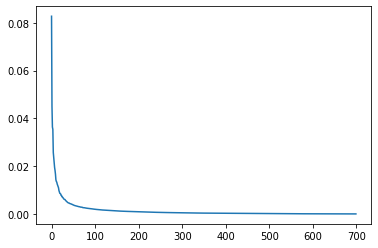

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=700)
pca.fit_transform(X_train)
plt.plot(pca.explained_variance_ratio_)


In [0]:
pca = PCA(n_components=313)
pca.fit_transform(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test) 

In [16]:
from sklearn.svm import SVC

svclassifier = SVC(kernel='linear', C=6.03e-01, class_weight= 'balanced')
svclassifier.fit(X_train_pca, y_train)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = svclassifier.predict(X_train_pca)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = svclassifier.predict(X_test_pca)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

---------------Scores on train---------------
[[862  98]
 [473 523]]
              precision    recall  f1-score   support

         0.0       0.65      0.90      0.75       960
         1.0       0.84      0.53      0.65       996

    accuracy                           0.71      1956
   macro avg       0.74      0.71      0.70      1956
weighted avg       0.75      0.71      0.70      1956

1956 621.0
0.6468769325912183
---------------Scores on test---------------
[[215 137]
 [ 26 111]]
              precision    recall  f1-score   support

         0.0       0.89      0.61      0.73       352
         1.0       0.45      0.81      0.58       137

    accuracy                           0.67       489
   macro avg       0.67      0.71      0.65       489
weighted avg       0.77      0.67      0.68       489

489 137.0
0.5766233766233767


### Cross Validation 

In [17]:
from tqdm import trange
n_split = 1
n_val = 800
cv_parameters = {'log_10_C': [-1, 2],
                 'n_comp':[10, 400] }
scores = []
log_10_cs = []
n_comps = []

progress_bar = trange(n_val, desc='Bar desc', leave=True)
for n in progress_bar:
    log_10_c = np.random.random() * (cv_parameters['log_10_C'][1] - cv_parameters['log_10_C'][0]) + cv_parameters['log_10_C'][0]
    n_comp = int(np.random.random() * (cv_parameters['n_comp'][1] - cv_parameters['n_comp'][0]) + cv_parameters['n_comp'][0])
    n_comps.append(n_comp)
    log_10_cs.append(log_10_c)
    f1_mean = []
    for split in range(n_split): 
        
        X_cv_train, X_val, y_cv_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=split)
        
        pca = PCA(n_components=n_comp)
        
        pca.fit_transform(X_train)
        X_train_pca = pca.transform(X_cv_train)
        X_test_pca = pca.transform(X_val)
        
        svclassifier = SVC(kernel='linear', C=10**log_10_c, class_weight= 'balanced')
        svclassifier.fit(X_train_pca, y_cv_train)
        
        y_pred = svclassifier.predict(X_test_pca)
        f1_mean.append(f1_score(y_pred,y_val))
    scores.append(np.mean(f1_mean))
    i_max = scores.index(max(scores))
    progress_bar.set_description('best f1 : {:.2e} |  for C = {:.2e} with {} components'.format(scores[i_max], 10**log_10_cs[i_max], n_comps[i_max]))
    progress_bar.refresh()
    
        
i_max = scores.index(max(scores))
print('best f1 : {:.2e} |  for C = {:.2e} with {} components'.format(scores[i_max], 10**log_10_cs[i_max], n_comps[i_max]))


best f1 : 6.25e-01 |  for C = 1.27e+01 with 26 components: 100%|██████████| 800/800 [14:20<00:00,  1.00it/s]

best f1 : 6.25e-01 |  for C = 1.27e+01 with 26 components


### Leave-one-out test score estimate
Because the amount of data is limited we evaluate the test score by training our classifier on the train set and all the test set but one example. 
We estimate the test score by taking the mean of the error computed when leaving all the sample of the test set alone once.


In [18]:

svclassifier = SVC(kernel='linear', C=9.03e-01, class_weight= 'balanced')
pca = PCA(n_components=28)

pca.fit_transform(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test) 

svclassifier.fit(X_train_pca, y_train)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = svclassifier.predict(X_train_pca)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = svclassifier.predict(X_test_pca)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

---------------Scores on train---------------
[[778 127]
 [557 494]]
              precision    recall  f1-score   support

         0.0       0.58      0.86      0.69       905
         1.0       0.80      0.47      0.59      1051

    accuracy                           0.65      1956
   macro avg       0.69      0.66      0.64      1956
weighted avg       0.70      0.65      0.64      1956

1956 621.0
0.5909090909090909
---------------Scores on test---------------
[[209 143]
 [ 25 112]]
              precision    recall  f1-score   support

         0.0       0.89      0.59      0.71       352
         1.0       0.44      0.82      0.57       137

    accuracy                           0.66       489
   macro avg       0.67      0.71      0.64       489
weighted avg       0.77      0.66      0.67       489

489 137.0
0.5714285714285714


In [19]:
svclassifier = SVC(kernel='linear', C=9.03e-01, class_weight= 'balanced')
pca = PCA(n_components=28)

pca.fit_transform(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test) 

y_pred=[]
for i in tqdm.tqdm(range(X_test_pca.shape[0])):
    X_train_all_but_one = np.concatenate([X_train_pca, X_test_pca[:i], X_test_pca[i+1:]])
    Y_train_all_but_one = np.concatenate([y_train, y_test[:i], y_test[i+1:]])
    svclassifier.fit(X_train_all_but_one, Y_train_all_but_one)
    y_pred.append(svclassifier.predict(np.asarray([X_test_pca[i]]))[0])
y_pred = np.asarray(y_pred)
print(y_pred.shape)
print(15*'-' +'Leave on out scores on test' + 15*'-' )
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

100%|██████████| 489/489 [01:43<00:00,  4.71it/s]

(489,)
---------------Leave on out scores on test---------------
[[213 139]
 [ 27 110]]
              precision    recall  f1-score   support

         0.0       0.89      0.61      0.72       352
         1.0       0.44      0.80      0.57       137

    accuracy                           0.66       489
   macro avg       0.66      0.70      0.64       489
weighted avg       0.76      0.66      0.68       489

489 137.0
0.5699481865284974


### PCA on all dataset

In [0]:
data_unnanotated = pd.read_csv('dataset_1.csv')

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


87.2239580154419
---------------Scores on train---------------
[[771 125]
 [564 496]]
              precision    recall  f1-score   support

         0.0       0.58      0.86      0.69       896
         1.0       0.80      0.47      0.59      1060

    accuracy                           0.65      1956
   macro avg       0.69      0.66      0.64      1956
weighted avg       0.70      0.65      0.64      1956

1956 621.0
0.5901249256395004
---------------Scores on test---------------
[[210 142]
 [ 25 112]]
              precision    recall  f1-score   support

         0.0       0.89      0.60      0.72       352
         1.0       0.44      0.82      0.57       137

    accuracy                           0.66       489
   macro avg       0.67      0.71      0.64       489
weighted avg       0.77      0.66      0.68       489

489 137.0
0.5728900255754475


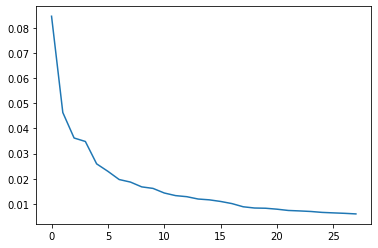

In [21]:
import time 
from sklearn.decomposition import PCA
from sklearn.svm import SVC

start = time.time()
unnanotated_embeded_data = data_unnanotated.head(10000)['solution'].map(lambda x : np.mean(embed_answer(x).reshape(-1,700),axis=0))
print(time.time()-start)
x = pd.DataFrame(np.asarray(unnanotated_embeded_data.tolist()).astype(np.float64))
x = x.dropna()

pca = PCA(n_components=28)
pca.fit_transform(x)
plt.plot(pca.explained_variance_ratio_)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


svclassifier = SVC(kernel='linear', C=9.03e-01, class_weight= 'balanced')
svclassifier.fit(X_train_pca, y_train)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = svclassifier.predict(X_train_pca)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = svclassifier.predict(X_test_pca)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

In [0]:
x['pred'] = svclassifier.predict(pca.transform(x))
x['Department'] = data_unnanotated['zip_code'] // 1000
x['zip_code'] = data_unnanotated['zip_code']
result_dataframe = x[['zip_code','Department', 'pred']]
result_dataframe.to_csv('results_pred.csv')


In [0]:

x = pd.read_csv('results_pred.csv')
unique_dpt = np.unique(x['Department'], return_counts=True)[0]
mapping = {'pred':{}}

for eval_type in mapping.keys():
    for dpt in unique_dpt:
        values = x[x['Department']==dpt][eval_type].dropna().values
        try:
            percentile = np.percentile(abs(values),95)
            valid_values = values[abs(values)<=percentile]

            M = np.mean(valid_values)
            V = np.var(valid_values)
        except:
            M, V = np.nan, np.nan

        mapping[eval_type][int(dpt)] = [M,V]

In [0]:
pd.options.mode.chained_assignment = None  # default='warn'

def plot_cartography(Colors, eval_type, figsize=(10, 6)):
    # set the filepath and load in a shapefile
    fp = 'map_files.shp'
    map_df = gpd.read_file(fp)
    # check data type so we can see that this is not a normal dataframe, but a GEOdataframe
    merged = map_df.set_index('code_insee').join(Colors.set_index('code_insee'))
    merged['colors']['2A'] = merged['colors']['2B'] = Colors['colors'][20]
    merged['colors']['69D'] = merged['colors']['69M'] = Colors['colors'][69]
    for idx in merged.index:
        if idx not in Colors['code_insee'].values and idx!='2A' and idx!='2B' and idx!='69D' and idx!='69M':
            merged = merged.drop(index=idx)
    merged.head()

    # set a variable that will call whatever column we want to visualise on the map
    variable = 'colors'
    # set the range for the choropleth
    vmin, vmax = np.min(merged[variable].values)-1e-5, np.max(merged[variable].values)
    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=figsize)

    # create map
    merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

    ax.axis('off')

    ax.set_title("French Departments, colors correpond to the mean of the argumentation scores : " + eval_type,
                 fontdict={'fontsize': '10', 'fontweight' : '3'})

    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # empty array for the data range
    sm._A = []
    # add the colorbar to the figure
    cbar = fig.colorbar(sm)

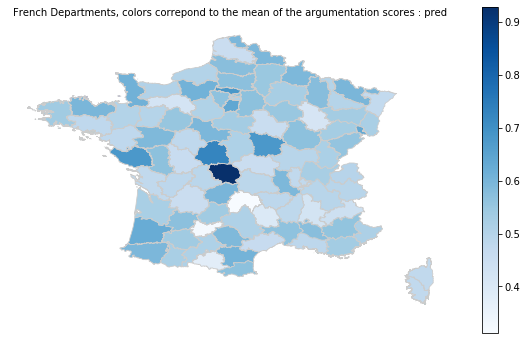

In [29]:
dpts = [k for k in range(1,96)]
for eval_type in ['pred']:
    Colors = []
    for dpt in dpts:
        Colors.append(mapping[eval_type][dpt][0]) # Because in the geopandas the departments go from 0 to 94

    Colors = pd.DataFrame(Colors, index=dpts, columns=['colors'])
    Colors = pd.concat([Colors, pd.DataFrame(['0'+str(k) for k in range(1,10)] + [str(k) for k in range(10,96)],
                                             index=dpts, columns=['code_insee'])], axis=1)

    plot_cartography(Colors, eval_type, figsize=(10,6))
    plt.savefig('../../{}.png'.format(eval_type))

### logistic regression

In [26]:
pca = PCA(n_components=500)
pca.fit_transform(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test) 


from sklearn.linear_model import LogisticRegression 
clf = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='ovr', C=100.0,
                        class_weight='balanced')

clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = clf.predict(X_train_pca)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = clf.predict(X_test_pca)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))



---------------Scores on train---------------
[[1071   96]
 [ 264  525]]
              precision    recall  f1-score   support

         0.0       0.80      0.92      0.86      1167
         1.0       0.85      0.67      0.74       789

    accuracy                           0.82      1956
   macro avg       0.82      0.79      0.80      1956
weighted avg       0.82      0.82      0.81      1956

1956 621.0
0.7446808510638299
---------------Scores on test---------------
[[240 112]
 [ 56  81]]
              precision    recall  f1-score   support

         0.0       0.81      0.68      0.74       352
         1.0       0.42      0.59      0.49       137

    accuracy                           0.66       489
   macro avg       0.62      0.64      0.62       489
weighted avg       0.70      0.66      0.67       489

489 137.0
0.49090909090909096


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [27]:
pca = PCA(n_components=30)
pca.fit_transform(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test) 


from sklearn.ensemble import RandomForestClassifier 


clf = RandomForestClassifier(n_estimators=190, max_depth=6, class_weight='balanced')
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = clf.predict(X_train_pca)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = clf.predict(X_test_pca)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

---------------Scores on train---------------
[[1060   58]
 [ 275  563]]
              precision    recall  f1-score   support

         0.0       0.79      0.95      0.86      1118
         1.0       0.91      0.67      0.77       838

    accuracy                           0.83      1956
   macro avg       0.85      0.81      0.82      1956
weighted avg       0.84      0.83      0.82      1956

1956 621.0
0.7717614804660727
---------------Scores on test---------------
[[259  93]
 [ 48  89]]
              precision    recall  f1-score   support

         0.0       0.84      0.74      0.79       352
         1.0       0.49      0.65      0.56       137

    accuracy                           0.71       489
   macro avg       0.67      0.69      0.67       489
weighted avg       0.74      0.71      0.72       489

489 137.0
0.5579937304075234


In [28]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(base_estimator=clf)
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = clf.predict(X_train_pca)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = clf.predict(X_test_pca)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

---------------Scores on train---------------
[[1279    0]
 [  56  621]]
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      1279
         1.0       1.00      0.92      0.96       677

    accuracy                           0.97      1956
   macro avg       0.98      0.96      0.97      1956
weighted avg       0.97      0.97      0.97      1956

1956 621.0
0.9568567026194145
---------------Scores on test---------------
[[298  54]
 [ 59  78]]
              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84       352
         1.0       0.59      0.57      0.58       137

    accuracy                           0.77       489
   macro avg       0.71      0.71      0.71       489
weighted avg       0.77      0.77      0.77       489

489 137.0
0.5799256505576208
